In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Load dataset
data = pd.read_csv("customer_support_tickets.csv")

In [3]:
# Display dataset info
print("Dataset Info:")
print(data.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   ob

In [4]:
print("\nMissing Values:\n", data.isnull().sum())


Missing Values:
 Ticket ID                          0
Customer Name                      0
Customer Email                     0
Customer Age                       0
Customer Gender                    0
Product Purchased                  0
Date of Purchase                   0
Ticket Type                        0
Ticket Subject                     0
Ticket Description                 0
Ticket Status                      0
Resolution                      5700
Ticket Priority                    0
Ticket Channel                     0
First Response Time             2819
Time to Resolution              5700
Customer Satisfaction Rating    5700
dtype: int64


In [5]:
print("\nFirst 5 Rows:")
print(data.head())


First 5 Rows:
   Ticket ID        Customer Name              Customer Email  Customer Age  \
0          1        Marisa Obrien  carrollallison@example.com            32   
1          2         Jessica Rios    clarkeashley@example.com            42   
2          3  Christopher Robbins   gonzalestracy@example.com            48   
3          4     Christina Dillon    bradleyolson@example.org            27   
4          5    Alexander Carroll     bradleymark@example.com            67   

  Customer Gender Product Purchased Date of Purchase      Ticket Type  \
0           Other        GoPro Hero       22-03-2021  Technical issue   
1          Female       LG Smart TV       22-05-2021  Technical issue   
2           Other          Dell XPS       14-07-2020  Technical issue   
3          Female  Microsoft Office       13-11-2020  Billing inquiry   
4          Female  Autodesk AutoCAD       04-02-2020  Billing inquiry   

             Ticket Subject  \
0             Product setup   
1  Periph

In [6]:
# Drop rows with missing values
data.dropna(inplace=True)

In [7]:
# Handle missing values
data["Customer Satisfaction Rating"] = data["Customer Satisfaction Rating"].fillna(data["Customer Satisfaction Rating"].median())
data["First Response Time"] = data["First Response Time"].bfill()
data["Time to Resolution"] = data["Time to Resolution"].bfill()

In [8]:
data.fillna("Unknown", inplace=True)

In [9]:
# Convert date columns to datetime format
data["Date of Purchase"] = pd.to_datetime(data["Date of Purchase"], errors='coerce', dayfirst=True)
data["First Response Time"] = pd.to_datetime(data["First Response Time"], errors='coerce', dayfirst=True)
data["Time to Resolution"] = pd.to_datetime(data["Time to Resolution"], errors='coerce', dayfirst=True)

In [10]:
# Creating new features
data["Response Delay (Hours)"] = (data["First Response Time"] - data["Date of Purchase"]).dt.total_seconds() / 3600
data["Resolution Time (Hours)"] = (data["Time to Resolution"] - data["First Response Time"]).dt.total_seconds() / 3600

In [11]:
data = data.copy()  # Create an explicit copy before modification
data.loc[:, "Response Delay (Hours)"] = data["Response Delay (Hours)"].fillna(data["Response Delay (Hours)"].median())
data.loc[:, "Resolution Time (Hours)"] = data["Resolution Time (Hours)"].fillna(data["Resolution Time (Hours)"].median())

In [12]:
# Categorizing satisfaction levels
def categorize_satisfaction(rating):
    if rating >= 4:
        return "Satisfied"
    elif rating == 3:
        return "Moderately Satisfied"
    else:
        return "Unsatisfied"

data["Satisfaction Level"] = data["Customer Satisfaction Rating"].apply(categorize_satisfaction)

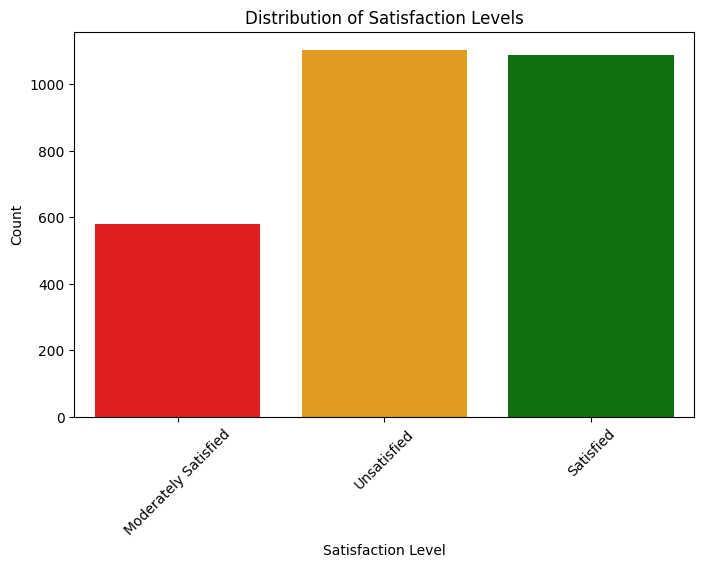

In [ ]:
# Bar chart for Satisfaction Levels
plt.figure(figsize=(8, 5))
sns.countplot(x="Satisfaction Level", data=data, hue="Satisfaction Level", palette=["red", "orange", "green"], legend=False)
plt.title("Distribution of Satisfaction Levels")
plt.xlabel("Satisfaction Level")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate labels for better visibility
plt.show()

In [14]:
# Encode categorical variables
categorical_cols = data.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col])

In [15]:
# Feature selection
X = data.drop(["Customer Satisfaction Rating", "Satisfaction Level"], axis=1)
y = data["Customer Satisfaction Rating"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [16]:
# Scale numerical features
print(X_train.dtypes)

Ticket ID                           int64
Customer Name                       int64
Customer Email                      int64
Customer Age                        int64
Customer Gender                     int64
Product Purchased                   int64
Date of Purchase           datetime64[ns]
Ticket Type                         int64
Ticket Subject                      int64
Ticket Description                  int64
Ticket Status                       int64
Resolution                          int64
Ticket Priority                     int64
Ticket Channel                      int64
First Response Time        datetime64[ns]
Time to Resolution         datetime64[ns]
Response Delay (Hours)            float64
Resolution Time (Hours)           float64
dtype: object


In [17]:
X_train["Date of Purchase"] = X_train["Date of Purchase"].astype("int64") // 10**9  # Convert to seconds
X_test["Date of Purchase"] = X_test["Date of Purchase"].astype("int64") // 10**9

In [18]:
for col in X_train.select_dtypes(include=['datetime64']).columns:
    X_train[col + '_year'] = X_train[col].dt.year
    X_train[col + '_month'] = X_train[col].dt.month
    X_train[col + '_day'] = X_train[col].dt.day
    X_train.drop(columns=[col], inplace=True)  # Remove original datetime column

for col in X_test.select_dtypes(include=['datetime64']).columns:
    X_test[col + '_year'] = X_test[col].dt.year
    X_test[col + '_month'] = X_test[col].dt.month
    X_test[col + '_day'] = X_test[col].dt.day
    X_test.drop(columns=[col], inplace=True)  # Remove original datetime column

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
# Model Training with Hyperparameter Tuning
param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]}
gscv = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
gscv.fit(X_train, y_train)
best_rfc = gscv.best_estimator_

In [21]:
y_train = y_train - 1
y_test = y_test - 1

In [22]:
# Handle missing values
imputer = SimpleImputer(strategy='mean')  # Replace NaNs with the mean value
X_train_imputed = imputer.fit_transform(X_train)

# Train XGBoost model
xgb = XGBClassifier(n_estimators=200, max_depth=10, random_state=42)
xgb.fit(X_train_imputed, y_train)

# Train SVM model
svc = SVC(kernel='linear', C=1.0, random_state=42)
svc.fit(X_train_imputed, y_train)

SVC(kernel='linear', random_state=42)

In [23]:
print(np.isnan(X_test).sum())

0


In [24]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [25]:
print("Train class distribution:\n", pd.Series(y_train).value_counts())
print("Test class distribution:\n", pd.Series(y_test).value_counts())

Train class distribution:
 Customer Satisfaction Rating
2.0    406
0.0    387
1.0    384
4.0    381
3.0    380
Name: count, dtype: int64
Test class distribution:
 Customer Satisfaction Rating
2.0    174
0.0    166
1.0    165
4.0    163
3.0    163
Name: count, dtype: int64


In [26]:
print("Unique labels in train set:", np.unique(y_train))
print("Unique labels in test set:", np.unique(y_test))

Unique labels in train set: [0. 1. 2. 3. 4.]
Unique labels in test set: [0. 1. 2. 3. 4.]


In [27]:
# Model Evaluation
def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    print(f"\n{name} Model Accuracy:", accuracy_score(y_test, y_pred))
    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
    print(f"\n{name} Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

evaluate_model(best_rfc, "Random Forest")
evaluate_model(xgb, "XGBoost")
evaluate_model(svc, "SVM")


Random Forest Model Accuracy: 0.15764139590854392

Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.00      0.00       166
         1.0       0.13      0.08      0.10       165
         2.0       0.20      0.18      0.19       174
         3.0       0.18      0.32      0.23       163
         4.0       0.19      0.21      0.20       163
         5.0       0.00      1.00      0.00         0

    accuracy                           0.16       831
   macro avg       0.29      0.30      0.12       831
weighted avg       0.34      0.16      0.14       831


Random Forest Confusion Matrix:
 [[ 0 19 33 54 33 27]
 [ 0 13 33 62 34 23]
 [ 0 24 32 60 35 23]
 [ 0 22 29 52 39 21]
 [ 0 19 33 58 34 19]
 [ 0  0  0  0  0  0]]

XGBoost Model Accuracy: 0.19494584837545126

XGBoost Classification Report:
               precision    recall  f1-score   support

         0.0       0.18      0.16      0.17       166
         1.0       

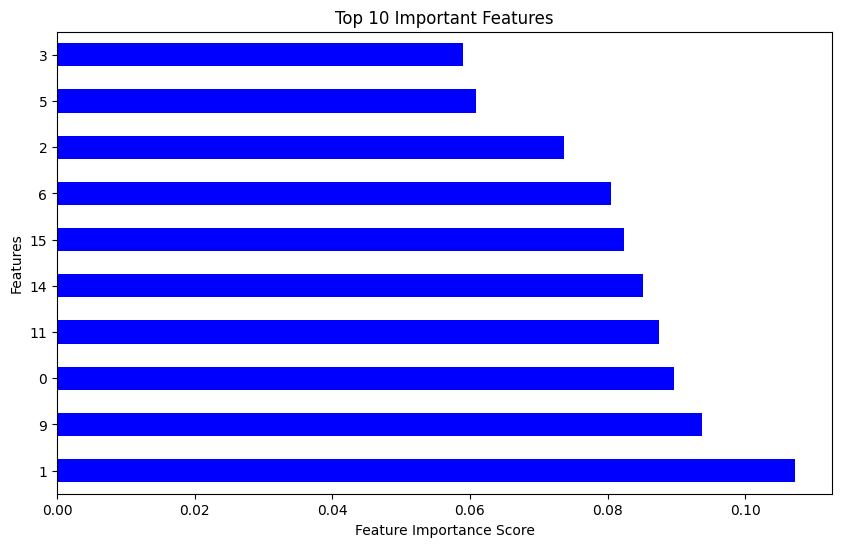

In [28]:
# Ensure X_train is a DataFrame with correct column names
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train)

# Use actual feature names from X_train if available, otherwise create placeholders
if hasattr(X_train, "columns"):
    feature_names = X_train.columns
else:
    feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]

# Convert X_train to DataFrame with proper column names
X_train = pd.DataFrame(X_train, columns=feature_names)

# Convert X to DataFrame and align with X_train columns
X = pd.DataFrame(X, columns=X_train.columns)

# Create Feature Importance Series
feature_importances = pd.Series(best_rfc.feature_importances_, index=X_train.columns)

# Plot Top 10 Important Features
plt.figure(figsize=(10, 6))
feature_importances.nlargest(10).plot(kind='barh', color='blue')
plt.title('Top 10 Important Features')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()


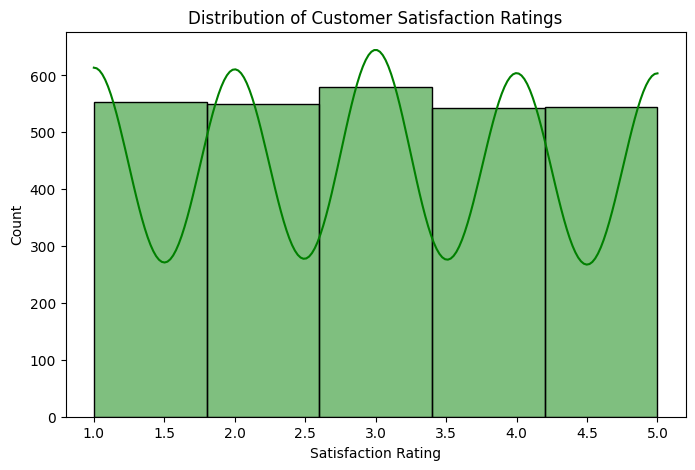

In [29]:
# Visualization: Customer Satisfaction Distribution
plt.figure(figsize=(8, 5))
sns.histplot(data['Customer Satisfaction Rating'], bins=5, kde=True, color='green')
plt.title('Distribution of Customer Satisfaction Ratings')
plt.xlabel('Satisfaction Rating')
plt.ylabel('Count')
plt.show()

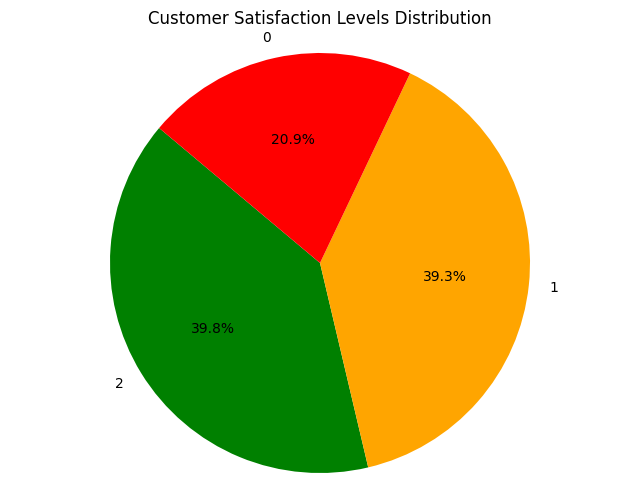

In [30]:
# Pie chart of satisfaction levels
plt.figure(figsize=(8, 6))
satisfaction_counts = data["Satisfaction Level"].value_counts()
plt.pie(satisfaction_counts, labels=satisfaction_counts.index, autopct='%1.1f%%', colors=['green', 'orange', 'red'], startangle=140)
plt.title("Customer Satisfaction Levels Distribution")
plt.axis('equal')
plt.show()

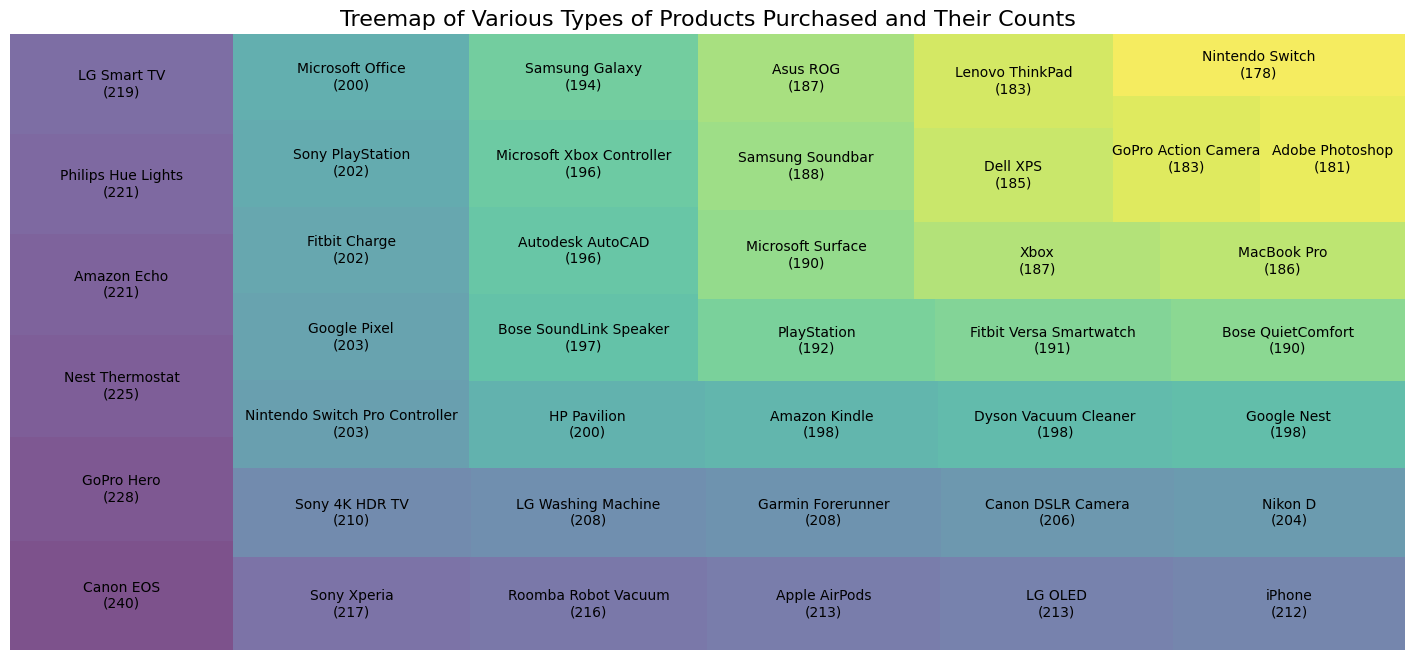

In [32]:
data=pd.read_csv("customer_support_tickets.csv")
# Ensure 'Product Purchased' column is treated as strings
data['Product Purchased'] = data['Product Purchased'].astype(str)

# Aggregate product purchase counts
product_counts = data['Product Purchased'].value_counts()

# Define sizes and labels
sizes = product_counts.values
labels = [f"{product}\n({count})" for product, count in zip(product_counts.index, sizes)]  # Newline for better spacing

# Set color palette
colors = sns.color_palette("viridis", len(sizes))

# Create figure
fig, ax = plt.subplots(figsize=(18,8))

# Plot treemap
squarify.plot(sizes=sizes, label=labels, alpha=0.7, color=colors, ax=ax)

# Formatting
plt.title("Treemap of Various Types of Products Purchased and Their Counts",fontsize=16)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# Show plot
plt.show()

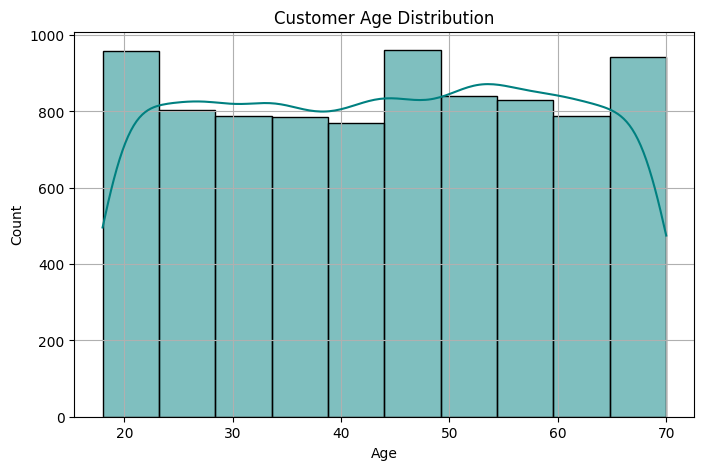

In [33]:
#customer age distribution
plt.figure(figsize=(8, 5))
sns.histplot(data['Customer Age'], bins=10, kde=True, color='teal')
plt.title("Customer Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.grid()
plt.show()

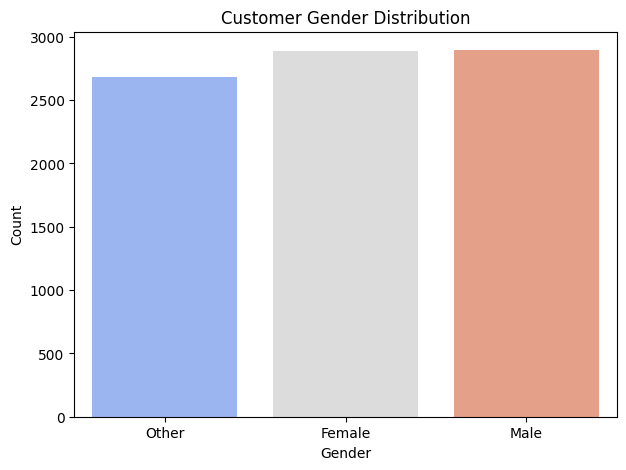

In [34]:
#customer gender distribution
plt.figure(figsize=(7, 5))
sns.countplot(x='Customer Gender', data=data, hue='Customer Gender', palette="coolwarm", legend=False)
plt.title("Customer Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

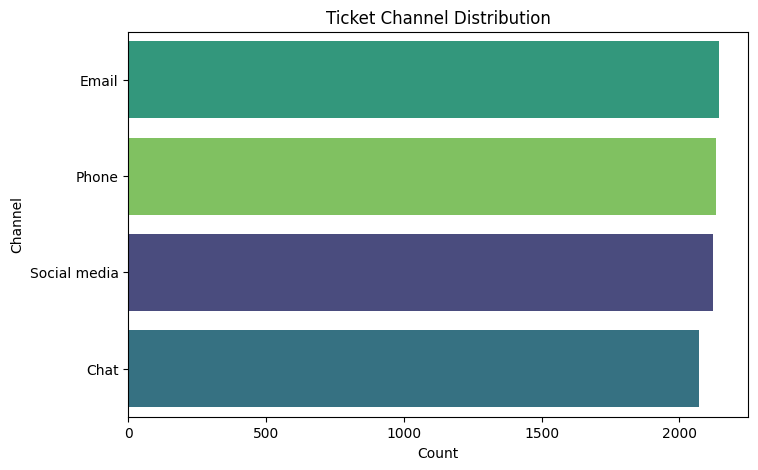

In [35]:
#ticket channel distribution
plt.figure(figsize=(8, 5))
sns.countplot(y='Ticket Channel', data=data, hue='Ticket Channel', palette="viridis", order=data['Ticket Channel'].value_counts().index, legend=False)
plt.title("Ticket Channel Distribution")
plt.xlabel("Count")
plt.ylabel("Channel")
plt.show()

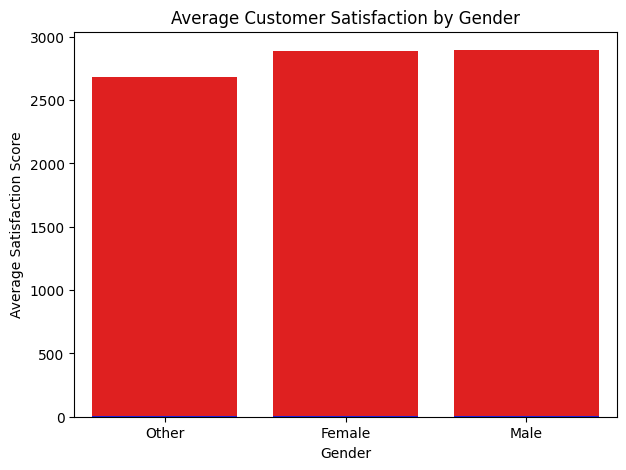

In [36]:
#average customer satisfaction by gender
plt.figure(figsize=(7, 5))
sns.countplot(x='Customer Gender', data=data, color="red")
sns.barplot(x='Customer Gender', y='Customer Satisfaction Rating', data=data, color="blue")
plt.title("Average Customer Satisfaction by Gender")
plt.xlabel("Gender")
plt.ylabel("Average Satisfaction Score")
plt.show()

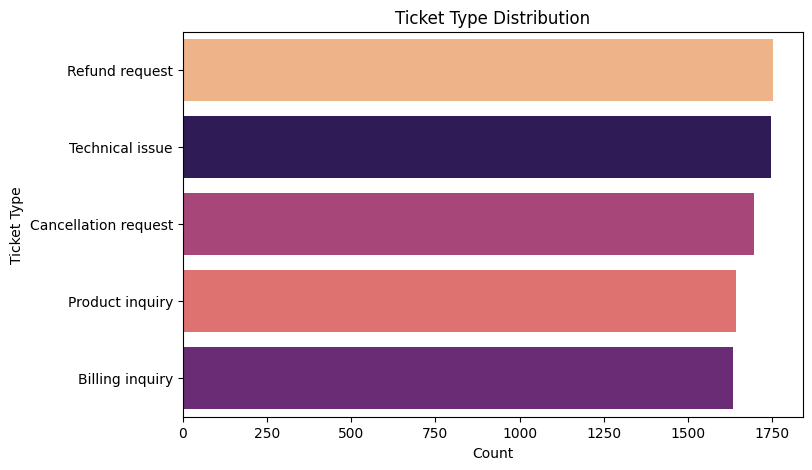

In [37]:
#ticket type distribution
plt.figure(figsize=(8, 5))
sns.countplot(y='Ticket Type', data=data, hue='Ticket Type', palette="magma", order=data['Ticket Type'].value_counts().index, legend=False)
plt.title("Ticket Type Distribution")
plt.xlabel("Count")
plt.ylabel("Ticket Type")
plt.show()

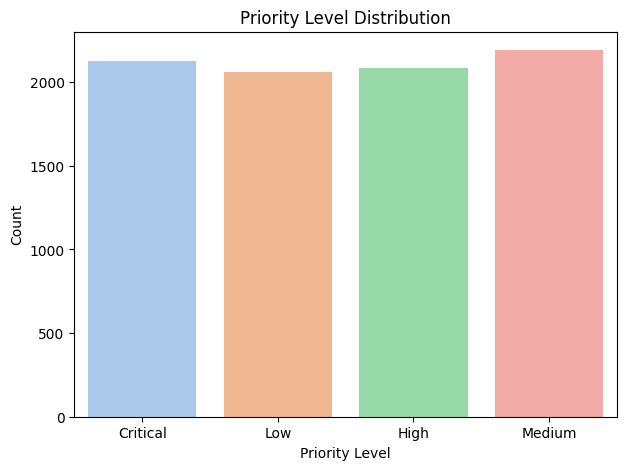

In [38]:
#priority level distribution
plt.figure(figsize=(7, 5))
sns.countplot(x='Ticket Priority', data=data, hue='Ticket Priority', palette="pastel", legend=False)
plt.title("Priority Level Distribution")
plt.xlabel("Priority Level")
plt.ylabel("Count")
plt.show()

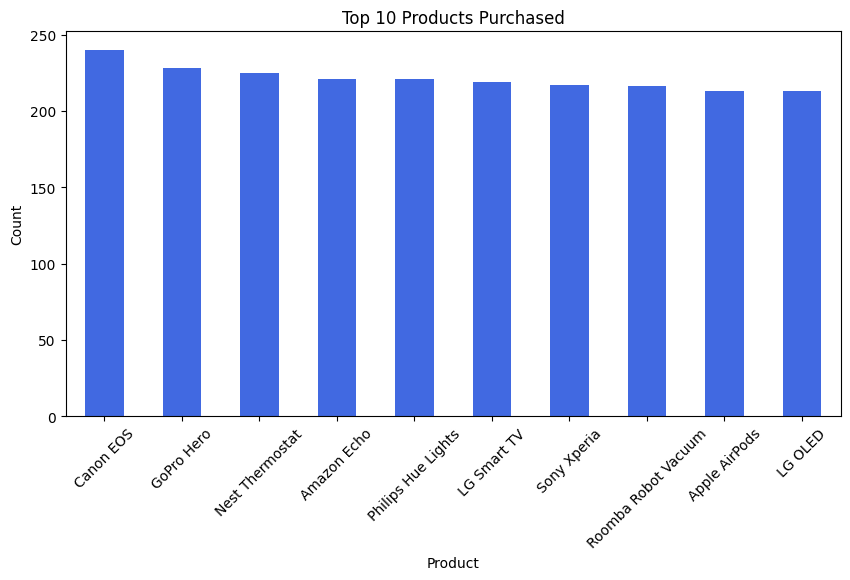

In [39]:
#top 10 products purchased
plt.figure(figsize=(10, 5))
data['Product Purchased'].value_counts().head(10).plot(kind='bar', color='royalblue')
plt.title("Top 10 Products Purchased")
plt.xlabel("Product")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

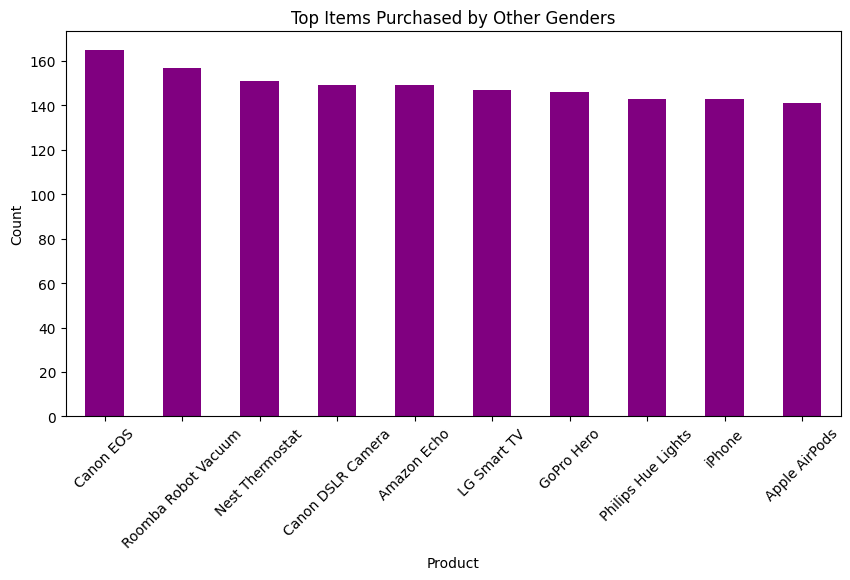

In [40]:
#top 10 items purchased by other gender
plt.figure(figsize=(10, 5))
other_genders = data[data['Customer Gender'] != 'Male']['Product Purchased'].value_counts().head(10)
other_genders.plot(kind='bar', color='purple')
plt.title("Top Items Purchased by Other Genders")
plt.xlabel("Product")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

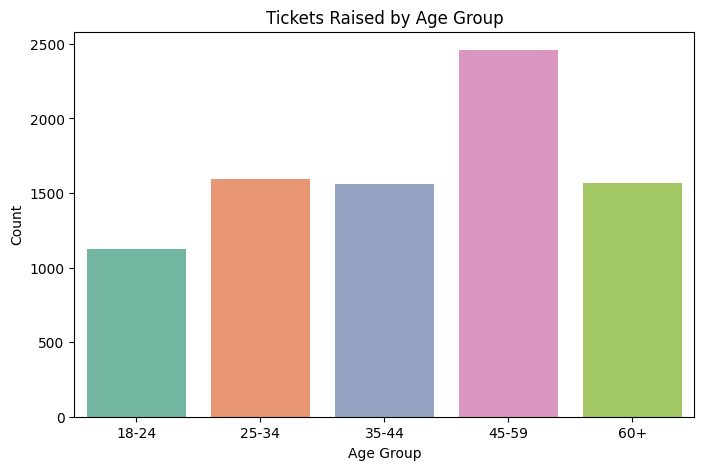

In [41]:
#tickets raised by age groups
# Creating age groups
bins = [18, 25, 35, 45, 60, 80]
labels = ['18-24', '25-34', '35-44', '45-59', '60+']
data['Age_Group'] = pd.cut(data['Customer Age'], bins=bins, labels=labels)

plt.figure(figsize=(8, 5))
sns.countplot(x='Age_Group', data=data, hue='Age_Group', palette="Set2", legend=False)
plt.title("Tickets Raised by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()